# Development of an Adaptable Deep Learning Model for Artistic Style Transfer

The aim of this assignment is to create a deep learning model capable of adapting an existing work to resemble the aesthetic of any art. The model should be able to analyze the artistic style of the selected art and apply similar stylistic features to a new, original artwork, creating a piece that seems as though it could have been created by the artist themselves.

as for the extracting style we used intermediate layers from pretrained VGG19 model fo extracting style and certain layers for content

Importing required libraries

In [1]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2
import warnings
warnings.filterwarnings('ignore')
from __future__ import print_function
import os
import time
from PIL import Image
import IPython.display as display
import matplotlib as mpl
import PIL.Image
import time
import functools
from keras import backend
from keras.models import Model
from keras.applications.vgg19 import VGG19

from scipy.optimize import fmin_l_bfgs_b

Loading content and styling images

In [2]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [3]:
content_image = load_image('C_image4.jpg')
style_image = load_image('S_image1.jpg')

visualize image

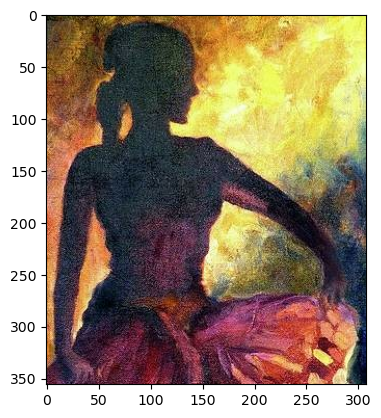

In [6]:
plt.imshow(np.squeeze(style_image))
plt.show()

The intermediate layers are crucial and to match the corrwesponding style the intermediate layers are to be considered. As the initial layers define the edges corners textures and as we advance the layers define the parts like eyes facial features. the VGG19 is a pretrained image classification network is used.

For the network to understand the image it has to include transforming the raw pixels into comprehensive understanding of features.

In [7]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)



80134624/80134624 [==============================] - 13s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choosing and seletcing all the intermediate layers as the style layers

In [8]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

The networks in tf.keras.applications are designed so you can easily extract the intermediate layer values using the Keras functional API.

In [9]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [10]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 356, 308, 64)
  min:  0.0
  max:  799.9585
  mean:  29.775887

block2_conv1
  shape:  (1, 178, 154, 128)
  min:  0.0
  max:  3556.4656
  mean:  149.31944

block3_conv1
  shape:  (1, 89, 77, 256)
  min:  0.0
  max:  10672.097
  mean:  143.2264

block4_conv1
  shape:  (1, 44, 38, 512)
  min:  0.0
  max:  16932.09
  mean:  630.0664

block5_conv1
  shape:  (1, 22, 19, 512)
  min:  0.0
  max:  2482.1956
  mean:  45.671455



It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.

In [11]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0070288065
    max:  80189.51
    mean:  634.27856

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  94428.664
    mean:  13620.538

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  365121.88
    mean:  11321.733

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4308305.0
    mean:  179315.5

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  144527.53
    mean:  1309.9291

Contents:
   block5_conv2
    shape:  (1, 31, 31, 512)
    min:  0.0
    max:  1190.3519
    mean:  12.07843


for gradient descent calculating the mean square error for image poutput relative to each target then taking the weighted sum

In [14]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [15]:
image = tf.Variable(content_image)

In [16]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
#creating an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [18]:
#to optimize this we use weighted combination of two losses to get the total loss
style_weight=1e-2
content_weight=1e4
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [19]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [21]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

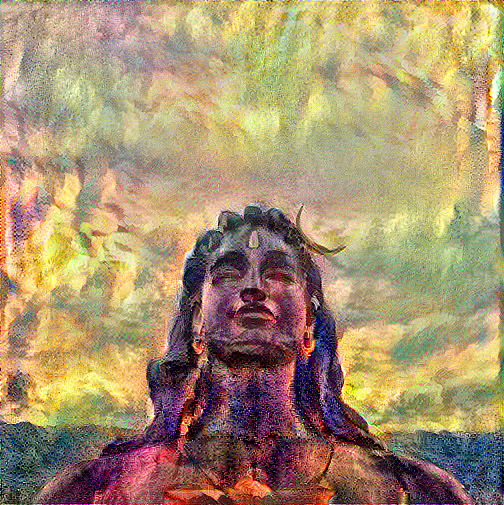

Train step: 1000
Total time: 6095.6


In [22]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

variation loss in style transfer is using the explicit regularization term on the high frequency components of image
the regularization loss is the sum of square if the values

In [23]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [24]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [25]:
total_variation_loss(image).numpy()

154818.84

In [26]:
tf.image.total_variation(image).numpy()

array([154818.84], dtype=float32)

In [27]:
#choosing a weight for total variation loss
total_variation_weight=30

In [28]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

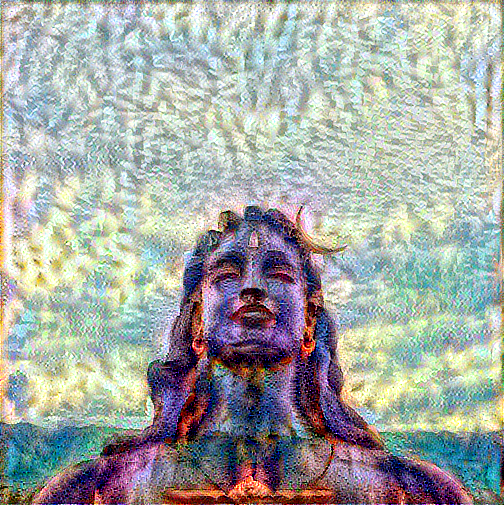

Train step: 100
Total time: 709.3


In [30]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 20

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))